In [1]:
import sys

sys.path.append("..")

!wget https://sergey-filimonov.nyc3.digitaloceanspaces.com/open-parse/sample-docs/lyft_2021-first-20-pages.pdf

--2025-02-13 01:48:36--  https://sergey-filimonov.nyc3.digitaloceanspaces.com/open-parse/sample-docs/lyft_2021-first-20-pages.pdf
Resolving sergey-filimonov.nyc3.digitaloceanspaces.com (sergey-filimonov.nyc3.digitaloceanspaces.com)... 162.243.189.2
Connecting to sergey-filimonov.nyc3.digitaloceanspaces.com (sergey-filimonov.nyc3.digitaloceanspaces.com)|162.243.189.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 379188 (370K) [application/pdf]
Saving to: ‘lyft_2021-first-20-pages.pdf’

lyft_2021-first-20- 100%[===================>] 370.30K  1.31MB/s    in 0.3s    

2025-02-13 01:48:37 (1.31 MB/s) - ‘lyft_2021-first-20-pages.pdf’ saved [379188/379188]



## Motivation

Chunking documents is fundamentally about grouping similar semantic nodes together. Perhaps the most powerful way to do this is to use embeddings.

### Considerations
1. We want to group similar elements together
2. If your chunking results in Nodes that are too small, you will miss out on valuable context that might be needed to understand the document
3. If your chunking results in Nodes that are too large, you will lose the ability to differentiate between different parts of the document

With that said, we have a bias towards chunking that results in larger nodes - models now have very large context windows. If you're building simpler RAG systems, you might want to chunk into smaller nodes to make the retrieval process more efficient.

A more thorough discussion can be found [here](https://www.llamaindex.ai/blog/evaluating-the-ideal-chunk-size-for-a-rag-system-using-llamaindex-6207e5d3fec5).

In [2]:
!pip install openparse

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.7/300.7 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 26.6 MB/s eta 0:00:00


In [3]:
# Jina AI API配置
JINA_API_URL = "https://api.jina.ai/v1/embeddings"
JINA_API_KEY = "jina_a1b9def7c7654a43ac6f1a10a74e10037V7YREhpO9SpAp7XhSn90Xbb4hyH"

def get_jina_embeddings(texts):
    """
    使用Jina AI API获取文本的嵌入向量
    """
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {JINA_API_KEY}",
    }
    data = {
        "model": "jina-clip-v2",
        "input": [{"text": text} for text in texts],
    }
    response = requests.post(JINA_API_URL, headers=headers, json=data)
    if response.status_code != 200:
        raise Exception(f"Failed to fetch embeddings: {response.text}")

    # 解析响应并提取嵌入向量
    embeddings = [item["embedding"] for item in response.json()["data"]]
    return embeddings

In [4]:
from openparse import Node
from openparse import processing
import numpy as np

def cosine_similarity(
    a: np.ndarray | list[float], b: np.ndarray | list[float]
) -> float:
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


def get_node_similarities(nodes):
    """
    计算每个节点与前一个节点的相似度
    """
    # 获取所有节点的嵌入向量
    embeddings = get_jina_embeddings([node.text for node in nodes])

    # 计算相似度
    similarities = []
    for i in range(1, len(embeddings)):
        similarities.append(cosine_similarity(embeddings[i - 1], embeddings[i]))

    # 将相似度保留两位小数，并在开头添加0（第一个节点没有前驱节点）
    similarities = [round(sim, 2) for sim in similarities]
    return [0] + similarities

## Visualizing Raw Node Similarity

Let's try applying some basic preprocessing to a sample document and visualize the similarity between the nodes.

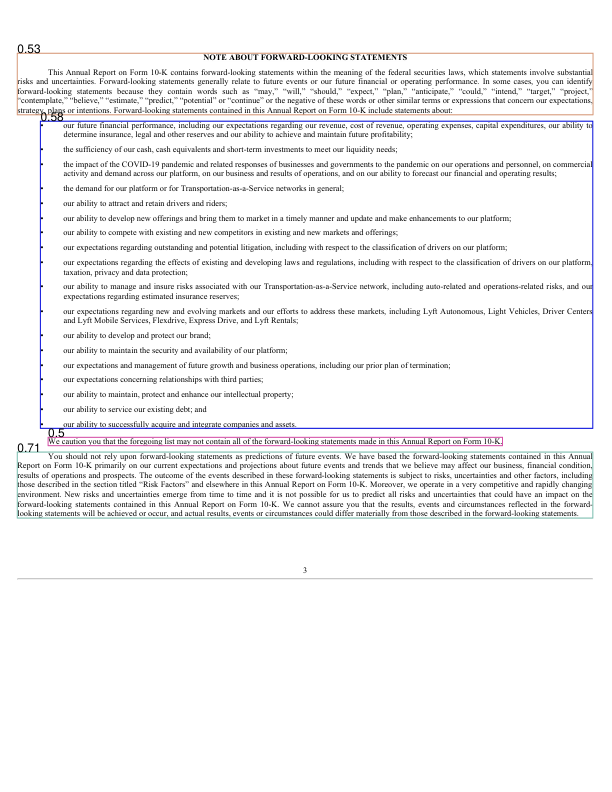

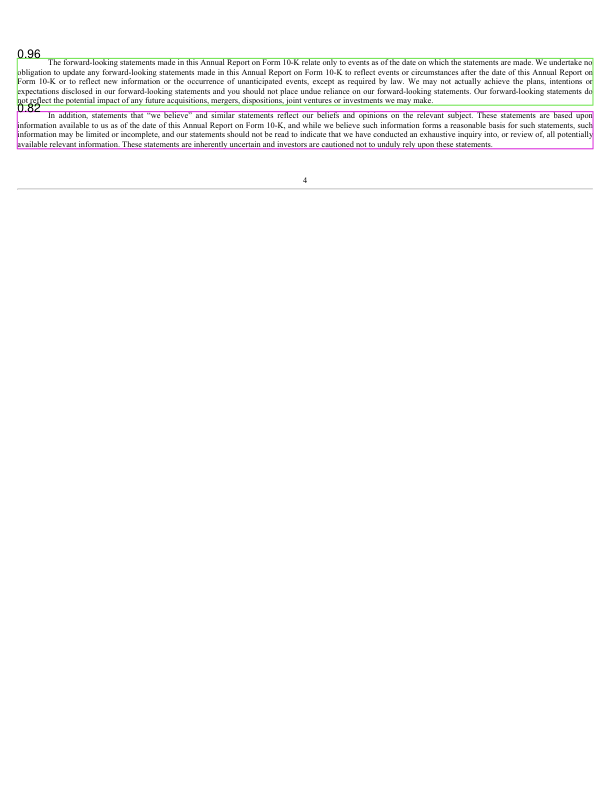

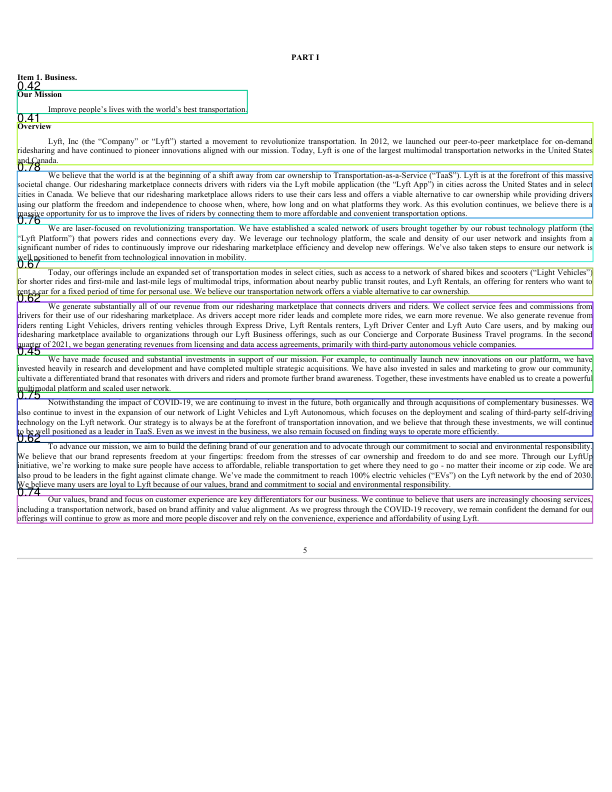

In [6]:
import openparse
from openparse import processing, Pdf
import requests

class MinimalIngestionPipeline(processing.IngestionPipeline):
    def __init__(self):
        self.transformations = [
            # combines bullets and weird formatting
            processing.CombineNodesSpatially(
                x_error_margin=10,
                y_error_margin=2,
                criteria="both_small",
            ),
            processing.CombineHeadingsWithClosestText(),
            processing.CombineBullets(),
            processing.RemoveMetadataElements(),
            processing.RemoveNodesBelowNTokens(min_tokens=10),
        ]


# perform very basic parsing to clean up the document
basic_doc_path = "/content/lyft_2021-first-20-pages.pdf"
doc = Pdf(file=basic_doc_path)
parser = openparse.DocumentParser(
    processing_pipeline=MinimalIngestionPipeline(),
)
parsed_content = parser.parse(basic_doc_path)

# annotate the document with similarity scores
annotations = get_node_similarities(parsed_content.nodes)
doc.display_with_bboxes(
    parsed_content.nodes, annotations=annotations, page_nums=[2, 3, 4]
)

## Now let's try combining these semantically

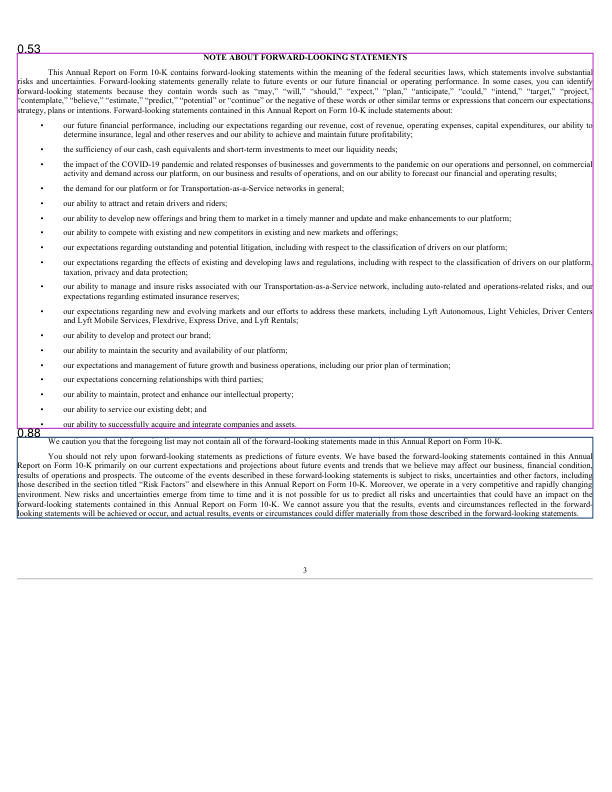

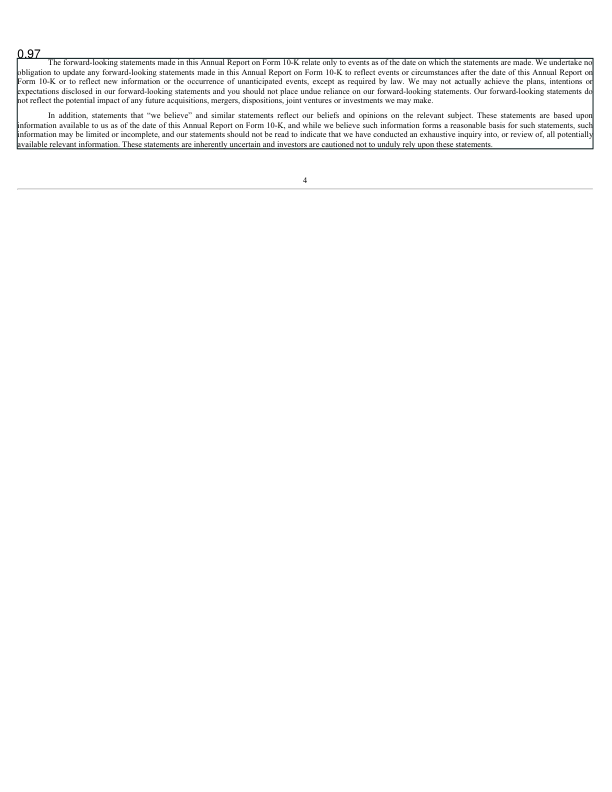

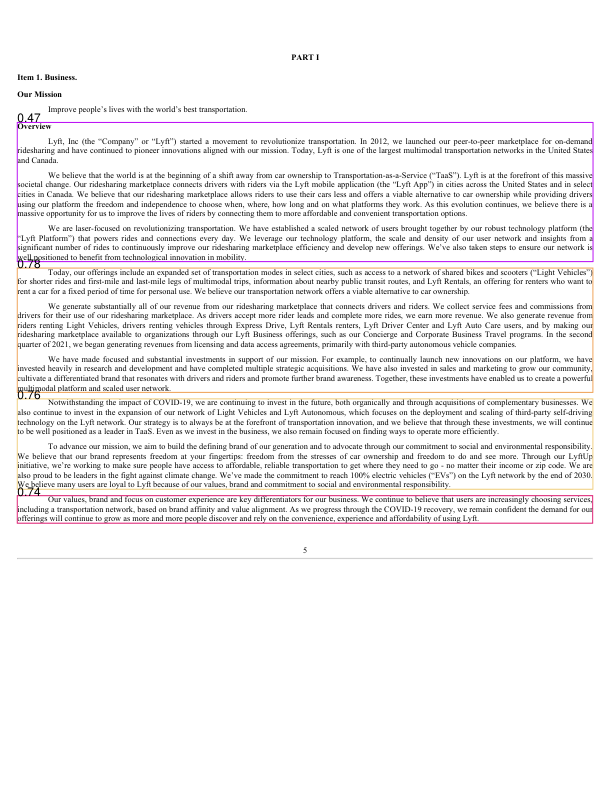

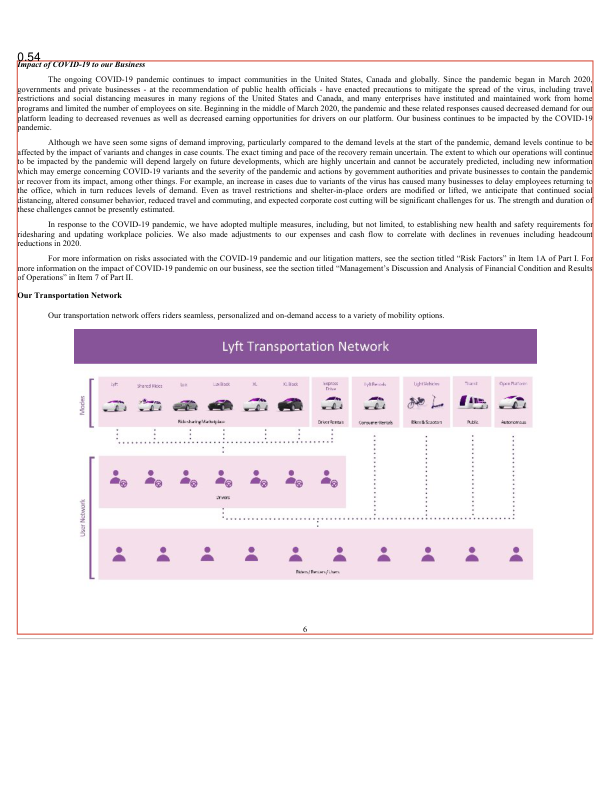

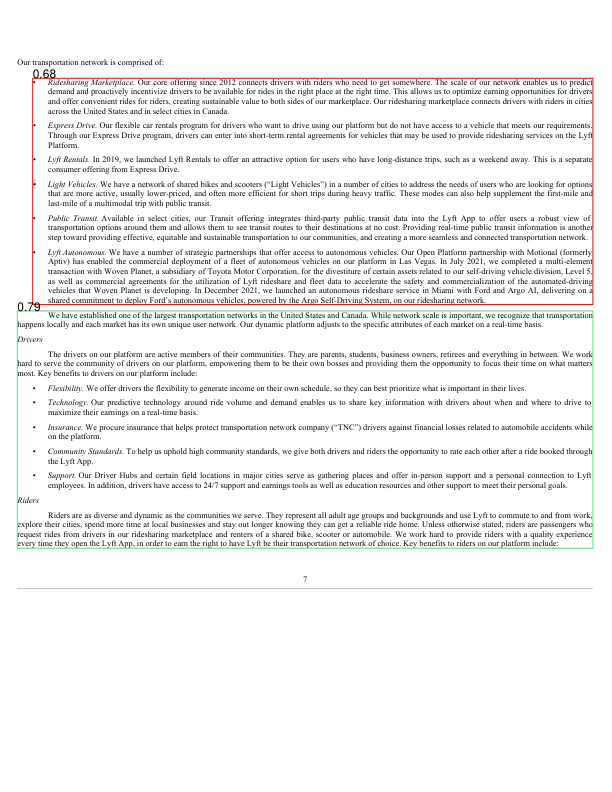

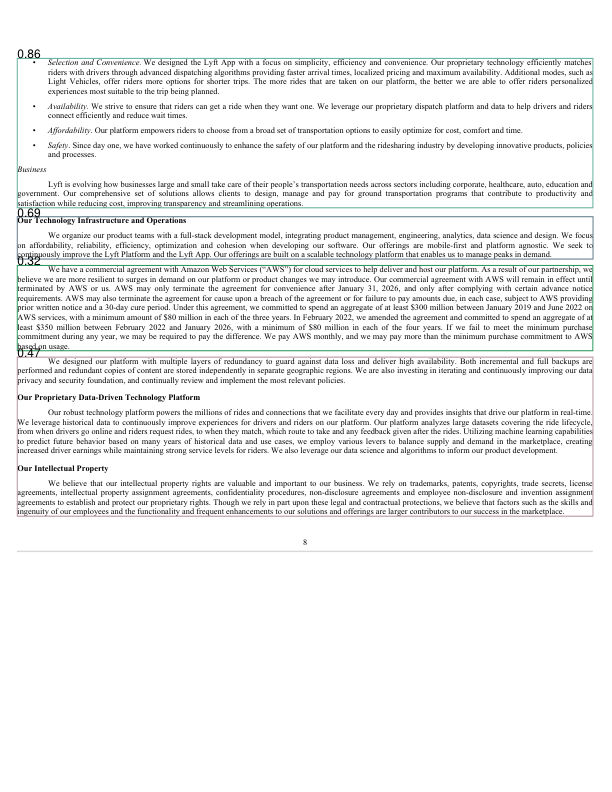

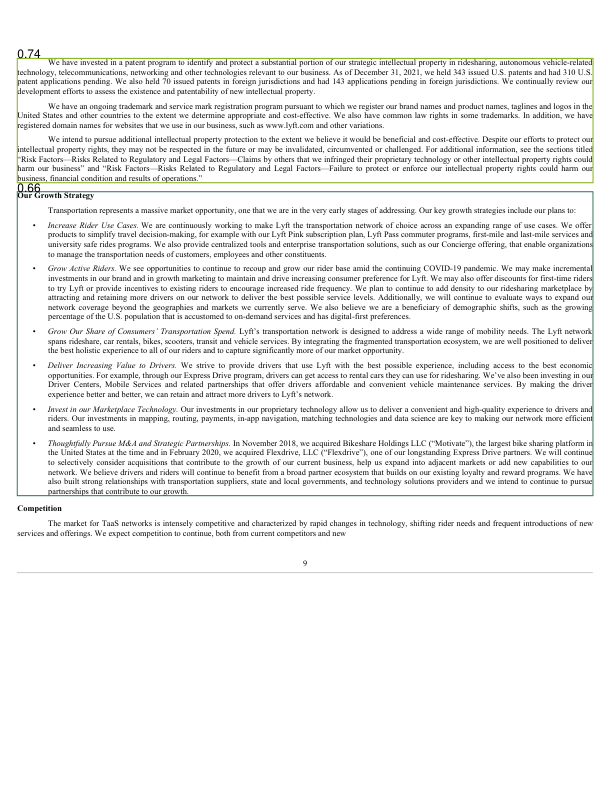

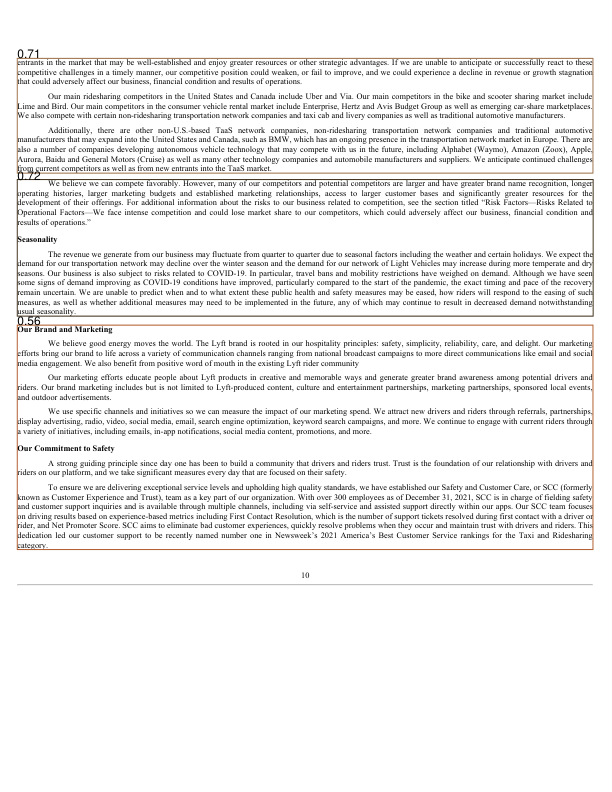

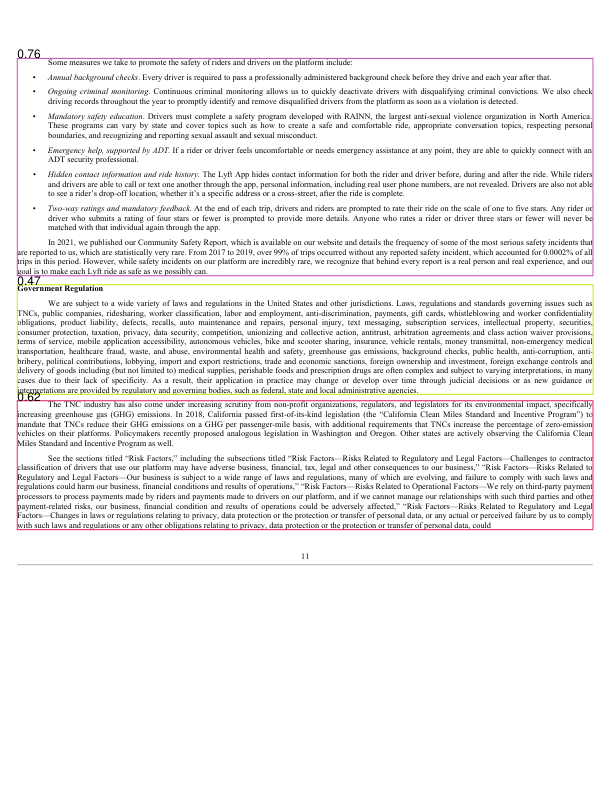

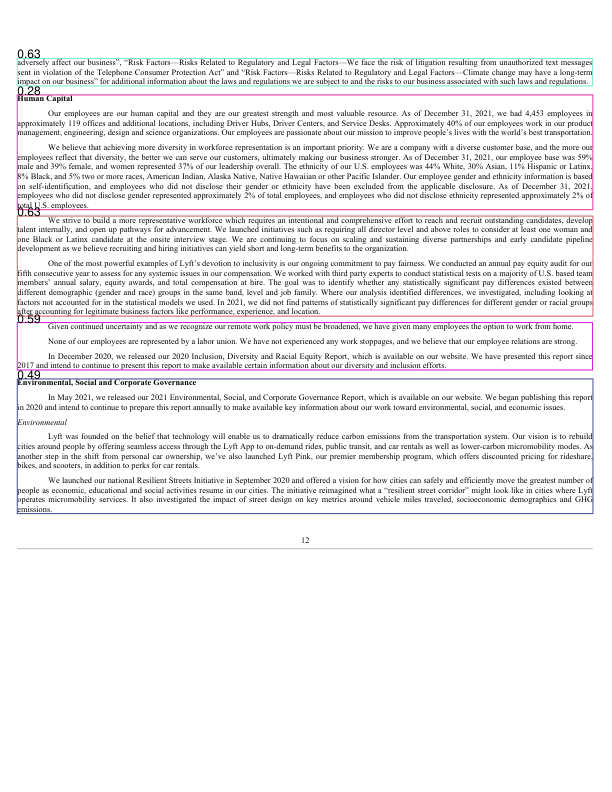

In [7]:
class JinaSemanticPipeline(processing.BasicIngestionPipeline):
    def __init__(self, min_tokens: int, max_tokens: int):
        super().__init__()
        self.min_tokens = min_tokens
        self.max_tokens = max_tokens

    def process(self, nodes):
        """
        处理节点列表，生成嵌入向量并存储到节点中
        """
        # 过滤掉过短或过长的节点
        filtered_nodes = [
            node for node in nodes
            if self.min_tokens <= len(node.text.split()) <= self.max_tokens
        ]

        # 获取嵌入向量
        embeddings = get_jina_embeddings([node.text for node in filtered_nodes])

        # 将嵌入向量存储到节点中
        for node, embedding in zip(filtered_nodes, embeddings):
            node.metadata["embedding"] = embedding

        return filtered_nodes

# 初始化语义处理管道
semantic_pipeline = JinaSemanticPipeline(
    min_tokens=64,
    max_tokens=1024,
)

# 初始化文档解析器
parser = openparse.DocumentParser(
    processing_pipeline=semantic_pipeline,
)

# 解析文档
basic_doc_path = "/content/lyft_2021-first-20-pages.pdf"  # 替换为你的文档路径
parsed_content = parser.parse(basic_doc_path)

# 计算节点之间的相似度
annotations = get_node_similarities(parsed_content.nodes)

# 显示文档并标注相似度
doc.display_with_bboxes(
    parsed_content.nodes,
    annotations=annotations,
    page_nums=list(range(2, 12)),  # 根据需要调整页码范围
)